In [150]:
import pandas as pd
import os

data_dir = "../scripts/dest"
pathogen_code = "abaumannii"

df = pd.read_csv(os.path.join(data_dir, pathogen_code, "01_{0}_cleaned.csv".format(pathogen_code)))
print("Considering only organism target types")
print("Before: {0}".format(df.shape))
df = df[df["target_type"] == "ORGANISM"]
print("After: {0}".format(df.shape))
df.drop(columns=["target_type"], inplace=True)
print("Considering only functional assay types")
print("Before: {0}".format(df.shape))
print(df.value_counts("assay_type"))
df = df[df["assay_type"] == "F"]
print("After: {0}".format(df.shape))
df.drop(columns=["assay_type"], inplace=True)

Considering only organism target types
Before: (33654, 16)
After: (33405, 16)
Considering only functional assay types
Before: (33405, 15)
assay_type
F    33294
A      104
B        7
Name: count, dtype: int64
After: (33294, 15)


In [151]:
df["direction_confidence"].value_counts()

direction_confidence
1    32650
0      644
Name: count, dtype: int64

In [152]:
df[df["direction_confidence"] == 0]

,activity_id,assay_id,target_id,inchikey,smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_relation,pchembl_value,activity_flag,direction_flag,direction_confidence
313,12406280,CHEMBL3047138,CHEMBL614425,LSQZJLSUYDQPKJ-NJBDSQKTSA-N,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,>,273.894155,uM,MBC,<,3.562417,0,-1,0
331,3308029,CHEMBL1119383,CHEMBL614425,JSPRBQBMZCATRZ-UHFFFAOYSA-N,CCCCCCCCCC(=O)Nc1ccccc1-c1cnc(N)[nH]1,=,40.000000,%,Activity,NaN,NaN,0,1,0
346,23229086,CHEMBL4826308,CHEMBL614425,MUZYEKLWXWDOOD-RUDZPDEXSA-N,CCCCCCCC(=O)N[C@@H](CCN)C(=O)N[C@H](C(=O)N[C@@...,<,0.025237,uM,MIC100,>,7.597964,0,-1,0
347,23228954,CHEMBL4826297,CHEMBL614425,MUZYEKLWXWDOOD-RUDZPDEXSA-N,CCCCCCCC(=O)N[C@@H](CCN)C(=O)N[C@H](C(=O)N[C@@...,=,0.025237,uM,MIC100,=,7.597964,0,-1,0
348,23229101,CHEMBL4826309,CHEMBL614425,MUZYEKLWXWDOOD-RUDZPDEXSA-N,CCCCCCCC(=O)N[C@@H](CCN)C(=O)N[C@H](C(=O)N[C@@...,=,0.050474,uM,MIC100,=,7.296934,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33455,5227013,CHEMBL1679707,CHEMBL614425,MYSWGUAQZAJSOK-UHFFFAOYSA-N,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,=,100.000000,%,Activity,NaN,NaN,0,1,0
33570,18528826,CHEMBL4194995,CHEMBL614425,HPNSFSBZBAHARI-RUDMXATFSA-N,COc1c(C)c2c(c(O)c1C/C=C(\C)CCC(=O)O)C(=O)OC2,=,19.430000,%,GI,NaN,NaN,0,1,0
33586,12406295,CHEMBL3047138,CHEMBL614425,OGJPXUAPXNRGGI-UHFFFAOYSA-N,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,=,117.505787,uM,MBC,=,3.929941,0,-1,0
33587,12406285,CHEMBL3047137,CHEMBL614425,OGJPXUAPXNRGGI-UHFFFAOYSA-N,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,=,130.666435,uM,MBC,=,3.883836,0,-1,0


In [ ]:
PCHEMBL_CUTOFFS = [5, 6, 7, 8, 9]
PERCENTAGE_ACTIVITY_CUTOFFS = [50, 75, 90]
PERCENTILES = [1, 5, 10, 25, 50]
MIN_SIZE_ASSAY_TASK = 500
MIN_SIZE_ASSAY_SUBTASK = 100
MAX_NUM_INDEPENDENT_ASSAYS = 5
MAX_NUM_ASSAY_SUBTASKS = 3
MIN_POSITIVES = 10

tasks_dir = os.path.join(data_dir, pathogen_code, "02_raw_tasks")
if not os.path.exists(tasks_dir):
    os.makedirs(tasks_dir)

def pchembl_binarizer(df):
    df = df[df["pchembl_value"].notnull()]
    df = df[df["pchembl_relation"].notnull()]
    data = {}
    for pchembl_cutoff in PCHEMBL_CUTOFFS:
        da = df[df["pchembl_value"] >= pchembl_cutoff]
        da = da[da["pchembl_relation"] != "<"]
        if da.shape[0] < MIN_POSITIVES:
            print("Not enough positives for pchembl cutoff {0}, {1}".format(pchembl_cutoff, da.shape[0]))
            continue
        di = df[df["pchembl_value"] < pchembl_cutoff]
        di = di[di["pchembl_relation"] != ">"]
        actives = [(ik, smi) for ik, smi in da[["inchikey", "smiles"]].values]
        inactives = [(ik, smi) for ik, smi in di[["inchikey", "smiles"]].values]
        data["pchembl_value_{0}".format(pchembl_cutoff)] = pd.DataFrame({"inchikey": [x[0] for x in actives] + [x[0] for x in inactives],
                                             "smiles": [x[1] for x in actives] + [x[1] for x in inactives],
                                             "pchembl_value_{}".format(pchembl_cutoff): [1] * len(actives) + [0] * len(inactives)})
    for percentile in PERCENTILES:
        df = df[df["pchembl_relation"] == "="]
        N = df.shape[0]
        n = int(N * percentile / 100)
        if n < MIN_POSITIVES:
            continue
        df = df.sort_values("pchembl_value", ascending=False)
        da = df.head(n)
        di = df.tail(N - n)
        actives = [(ik, smi) for ik, smi in da[["inchikey", "smiles"]].values]
        inactives = [(ik, smi) for ik, smi in di[["inchikey", "smiles"]].values]
        data["pchembl_percentile_{0}".format(percentile)] = pd.DataFrame({"inchikey": [x[0] for x in actives] + [x[0] for x in inactives],
                                             "smiles": [x[1] for x in actives] + [x[1] for x in inactives],
                                             "pchembl_percentile_{}".format(percentile): [1] * len(actives) + [0] * len(inactives)})
    return data


def percentage_activity_binarizer(df):
    df = df[df["standard_value"].notnull()]
    df = df[df["standard_relation"].notnull()]
    df = df[df["standard_units"] == "%"]
    df = df[df["direction_flag"] == 1]
    data = {}
    for percentage_activity_cutoff in PERCENTAGE_ACTIVITY_CUTOFFS:
        da = df[df["standard_value"] >= percentage_activity_cutoff]
        da = da[da["standard_relation"] != "<"]
        if da.shape[0] < MIN_POSITIVES:
            continue
        di = df[df["standard_value"] < percentage_activity_cutoff]
        di = di[di["standard_relation"] != ">"]
        actives = [(ik, smi) for ik, smi in da[["inchikey", "smiles"]].values]
        inactives = [(ik, smi) for ik, smi in di[["inchikey", "smiles"]].values]
        data["percentage_activity_{0}".format(percentage_activity_cutoff)] = pd.DataFrame({"inchikey": [x[0] for x in actives] + [x[0] for x in inactives],
                                             "smiles": [x[1] for x in actives] + [x[1] for x in inactives],
                                             "percentage_activity_{}".format(percentage_activity_cutoff): [1] * len(actives) + [0] * len(inactives)})
    for percentile in PERCENTILES:
        df = df[df["standard_relation"] == "="]
        N = df.shape[0]
        n = int(N * percentile / 100)
        if n < MIN_POSITIVES:
            continue
        df = df.sort_values("standard_value", ascending=False)
        da = df.head(n)
        di = df.tail(N - n)
        actives = [(ik, smi) for ik, smi in da[["inchikey", "smiles"]].values]
        inactives = [(ik, smi) for ik, smi in di[["inchikey", "smiles"]].values]
        data["percentage_activity_percentile_{0}".format(percentile)] = pd.DataFrame({"inchikey": [x[0] for x in actives] + [x[0] for x in inactives],
                                             "smiles": [x[1] for x in actives] + [x[1] for x in inactives],
                                             "percentage_activity_percentile_{}".format(percentile): [1] * len(actives) + [0] * len(inactives)})
    return data


def active_inactive_binarizer(df):
    df = df[df["activity_flag"] != 0]
    data = {}
    da = df[df["activity_flag"] == 1]
    di = df[df["activity_flag"] == -1]
    actives = [(ik, smi) for ik, smi in da[["inchikey", "smiles"]].values]
    inactives = [(ik, smi) for ik, smi in di[["inchikey", "smiles"]].values]
    data["labeled_active"] = pd.DataFrame({"inchikey": [x[0] for x in actives] + [x[0] for x in inactives],
                                            "smiles": [x[1] for x in actives] + [x[1] for x in inactives],
                                            "labeled_active": [1] * len(actives) + [0] * len(inactives)})
    return data


# here we either do not merge units
# or we merge the ones that have a confident direction
def others_binarizer(df):
    data = {}
    return data


# Select up to 5 assays with at least 100 molecules

assay_ids = [x for x in df.value_counts("assay_id").index]
counts = [x for x in df.value_counts("assay_id")]
sel_assay_ids = []
for aid, count in zip(assay_ids, counts):
    if count >= MIN_SIZE_ASSAY_TASK:
        sel_assay_ids.append(aid)
    else:
        break
sel_assay_ids = sel_assay_ids[:MAX_NUM_INDEPENDENT_ASSAYS]

for aid in sel_assay_ids:
    print("Assay ID: {0}".format(aid))
    dt = df[df["assay_id"] == aid]
    activity_types = [x for x in dt.value_counts("standard_type").index]
    counts = [x for x in dt.value_counts("standard_type")]
    sel_activity_types = []
    for at, count in zip(activity_types, counts):
        if count >= MIN_SIZE_ASSAY_SUBTASK:
            sel_activity_types.append(at)
    sel_activity_types = sel_activity_types[:MAX_NUM_ASSAY_SUBTASKS]
    for activity_type in activity_types:
        dtt = dt[dt["standard_type"] == activity_type]
        for has_pchembl in [True, False]:
            if has_pchembl:
                dttp = dtt[dtt["pchembl_value"].notnull()]
                if dttp.shape[0] < MIN_SIZE_ASSAY_SUBTASK:
                    continue
                data = pchembl_binarizer(dttp)
            else:
                dttp = dtt[dtt["pchembl_value"].isnull()]
                if dttp.shape[0] < MIN_SIZE_ASSAY_SUBTASK:
                    continue
                for has_percentage_activity in [True, False]:
                    if has_percentage_activity:
                        dttpp = dttp[dttp["standard_units"] == "%"]
                        if dttpp.shape[0] < MIN_SIZE_ASSAY_SUBTASK:
                            continue
                        data = percentage_activity_binarizer(dttpp)
                        print(data.keys())
                    else:
                        dttpp = dttp[dttp["standard_value"].isnull()]
                        if dttpp.shape[0] < MIN_SIZE_ASSAY_SUBTASK:
                            continue
                        data = others_binarizer(dttpp)

Assay ID: CHEMBL4296188
dict_keys(['percentage_activity_percentile_1', 'percentage_activity_percentile_5', 'percentage_activity_percentile_10', 'percentage_activity_percentile_25', 'percentage_activity_percentile_50'])
Not enough positives for pchembl cutoff 6, 3
Not enough positives for pchembl cutoff 7, 0
Not enough positives for pchembl cutoff 8, 0
Not enough positives for pchembl cutoff 9, 0
Assay ID: CHEMBL4296193
dict_keys(['percentage_activity_percentile_1', 'percentage_activity_percentile_5', 'percentage_activity_percentile_10', 'percentage_activity_percentile_25', 'percentage_activity_percentile_50'])


In [176]:
test = df[df["assay_id"] == "CHEMBL4296188"]
test = test[test["standard_units"] == "%"]
test.shape

(21555, 14)

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        6.000e+00, 1.200e+01, 5.000e+00, 8.000e+00, 1.400e+01, 9.000e+00,
        1.100e+01, 1.800e+01, 2.500e+01, 2.600e+01, 4.600e+01, 4.800e+01,
        5.900e+01, 6.700e+01, 1.120e+02, 1.350e+02, 2.100e+02, 2.500e+02,
        3.660e+02, 5.810e+02, 6.790e+02, 9.150e+02, 1.115e+03, 1.304e+03,
        1.507e+03, 1.671e+03, 1.684e+03, 1.633e+03, 1.564e+03, 1.367e+03,
        1.151e+03, 9.850e+02, 7.920e+02, 6.440e+02, 4.980e+02, 4.100e+02,
        2.920e+02, 2.430e+02, 2.000e+02, 1.380e+02, 1.120e+02, 9.900e+01,
        6.300e+01, 5.200e+01, 6.000e+01, 5.000e+01, 3.900e+01, 3.200e+01,
        2.600e+01, 2.300e+01, 2.400e+0

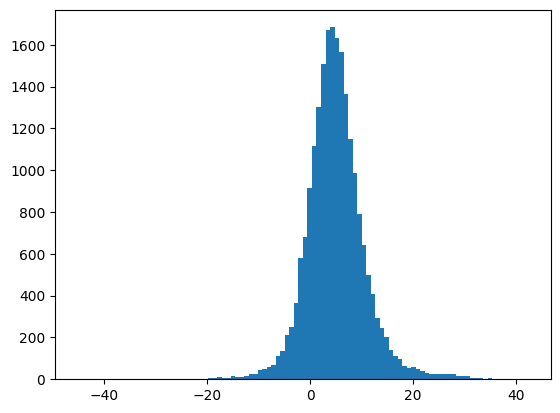

In [178]:
plt.hist(test["standard_value"], bins=100)

(array([195.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   2.,   3.,   5.,
          1.,   2.,   5.,   6.,   7.,  10.,  10.,   2.,   9.,   5.,   1.,
          2.,   8.,   5.,   1.,   3.,  12.,  10.,  16.,  15.,  17.,   9.,
          9.,   0.,   0.,   1.,   1.,   0.,   0.,   0., 392.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 267.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([3.52287875, 3.55153929, 3.58019984, 3.60886039, 3.63752094,
        3.66618149, 3.69484204, 3.72350258, 3.75216313, 3.78082368,
        3.80948423, 3.83814478, 3.86680533, 3.89546587, 3.92412642,
        3.95278697, 3.98144752, 4.01010807, 4.03876862, 4.06742916,
        4.09608971, 4.12475026, 4.15341081, 4.

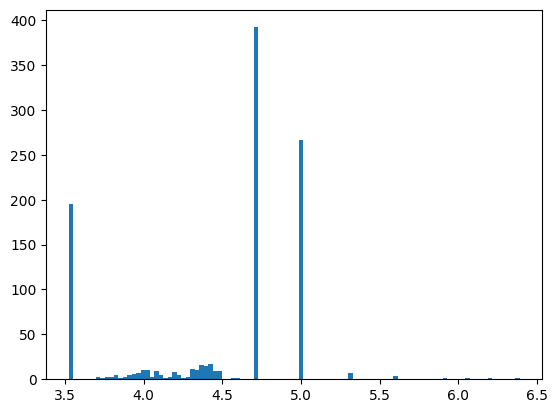

In [165]:
plt.hist(df[df["assay_id"] == "CHEMBL4296188"]["pchembl_value"], bins=100)

In [ ]:
for pchembl_cut in PCHEMBL_CUTS:
    PCHEMBL_CUTS = [4, 5, 6, 7]



(array([  17.,   56.,  876., 2983., 2661., 1663.,  779.,  272.,   51.,
          32.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

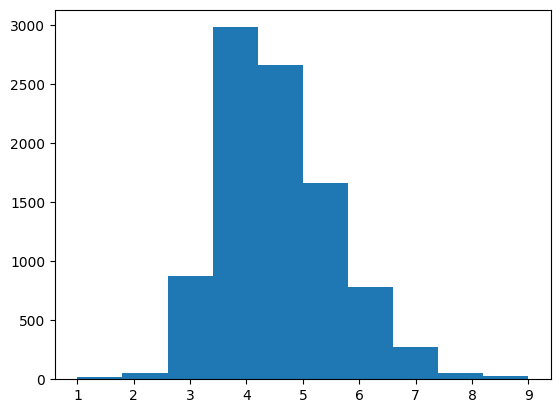

In [131]:
import matplotlib.pyplot as plt

plt.hist(df["pchembl_value"])